<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/experiments/RNN_add_unk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [472]:
! git clone https://github.com/shiwentao00/Molecule-RNN.git --quiet

fatal: destination path 'Molecule-RNN' already exists and is not an empty directory.


In [473]:
! pip install rdkit --quiet
! pip install selfies --quiet

In [474]:
cd Molecule-RNN

/content/Molecule-RNN


In [475]:
import torch
import re
import yaml
import selfies as sf
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from tqdm import tqdm

# import yaml
import os
# import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
# import selfies as sf
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

In [485]:
selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'

with open(selfie_vocab_path, 'r') as f:
    prev_vocab = yaml.full_load(f)
print(len(prev_vocab))
print('add <unk>')
prev_vocab['<unk>'] = len(prev_vocab)+1
print(len(prev_vocab))
with open('/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_add_unk.yaml', 'w') as f:
    yaml.dump(prev_vocab, f)

78
add <unk>
79


In [486]:
smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
# new_selfie_vocab_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_no_eos.yaml'
# selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'
# alphabet_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_pad_then_sos.yaml'
alphabet_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_add_unk.yaml'

rnn_config = {
    'data_dir': smile_dir,
    'vocab_dir': alphabet_path,

    'num_embeddings': 79,
    'embedding_dim': 256,
    'rnn_type': "GRU",

    "input_size": 256,
    'hidden_size': 512,
    'latent_size': 76,
    'num_layers': 3,
    'dropout': 0,

    'token_weights':None,
    'max_token_len': 50,
    'num_dilated_layers':7,
    'num_channels': 128,


    'beta': 0.001,
    'gamma':0.1,


    "batch_size": 512,
    'shuffle': True,
    'num_epoch': 10,
    'which_optimizer': 'adam',
    'learning_rate': 0.001,
    'weight_decay': 1.0e-4
}



In [487]:
# selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'


####################
####################
####################
class SELFIEVocab:
    def __init__(self, vocab_path):
        self.name ='selfies'
        with open(vocab_path, 'r') as f: self.vocab = yaml.full_load(f)
        self.int2token = {value:key for key, value in self.vocab.items()}

    def tokenize_smiles(self, mol): #mol is selfie actually
        ints = [self.vocab['<sos>']]
        selfies_list = list(sf.split_selfies(mol))
        ########################################################################
        # add <unk>
        for token in selfies_list:
            if token in self.vocab.keys(): ints.append(self.vocab[token])
            else:
                assert '<unk>' in self.vocab.keys()
                ints.append(self.vocab['<unk>'])
        # ints += [self.vocab[token] for token in selfies_list]
        ########################################################################
        ints.append(self.vocab['<eos>'])
        return ints
    def combine_list(self, selfies): return "".join(selfies)

####################
####################
####################

import pandas as pd
import random
class SMILESDataset(Dataset):
    def __init__(self, smiles_file, percentage, vocab):
        super(SMILESDataset, self).__init__()
        assert (0<percentage<=1)
        self.percentage = percentage
        self.vocab = vocab
        if smiles_file.split('.')[-1] == 'smi':
            self.data = self.read_smiles_file(smiles_file)
        elif smiles_file.split('.')[-1] == 'csv':
            self.data = self.read_csv_file(smiles_file)
        print('total number of SMILES loaded: ', len(self.data))

        if self.vocab.name == 'selfies':
            self.data = self.smi2sf()
            print('total valid SELFIES:', len(self.data))

    def __getitem__(self, index):
        s_mol = self.data[index]
        vec_mol = self.vocab.tokenize_smiles(s_mol)
        return vec_mol

    def __len__(self): return len(self.data)

    def smi2sf(self):
        smiles = self.data
        sfs = []
        for i in tqdm(smiles, total=len(smiles)):
            try:
                s_ = sf.encoder(i)
                if s_ is not None: sfs.append(s_)
            except: pass
        return sfs


    def read_smiles_file(self, path):
        with open(path, 'r') as f:
            smiles = [line.strip("\n") for line in f.readlines()]

        select_num = int(len(smiles)*self.percentage)
        return random.choices(smiles, k=select_num)

    def read_csv_file(self, path):
        data = pd.read_csv(path)
        for i in ['Smiles', 'smiles', 'SMILES']:
            if i in data.columns:
                smiles = data[i].tolist()
                select_num = int(len(smiles)*self.percentage)
                return random.choices(smiles, k=select_num)

smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
# selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'

def dataloader_gen(percentage, batch_size, PADDING_IDX, shuffle,
                   dataset_dir=smile_dir, which_vocab='selfies',
                   vocab_path=selfie_vocab_path, drop_last=True):
    print('which_vocab:', which_vocab)
    if which_vocab == 'selfies':
        vocab = SELFIEVocab(vocab_path)
        dataset = SMILESDataset(dataset_dir, percentage, vocab)
    else:
        dataset = None
        vocab = None

    def pad_collate(batch):
        lengths = [len(x) for x in batch]
        batch = [torch.tensor(x, dtype=torch.long) for x in batch]
        x_padded = pad_sequence(batch, batch_first=True,
                                padding_value=PADDING_IDX)
        return x_padded, lengths

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last,
                            collate_fn=pad_collate)
    return dataloader, len(dataset)

CHANGE vocab

In [490]:
vocab = SELFIEVocab(rnn_config['vocab_dir'])
percentage = 0.1
PADDING_IDX = vocab.vocab['<pad>']
num_workers = os.cpu_count()
batch_size = rnn_config['batch_size']
shuffle = rnn_config['shuffle']
# vocab.vocab['<pad>'], vocab.vocab['<sos>'], len(vocab.vocab)
which_vocab = 'selfies'

print('number of workers to load data:', num_workers)
print('which vocab to use: ', which_vocab)
try:
    assert(rnn_config['num_embeddings'] == len(vocab.vocab))
except:
    raise ValueError('difference in len alphabet, change rnn_config')


dataloader, train_size = dataloader_gen(percentage, batch_size, PADDING_IDX,
                                        shuffle, drop_last=False)

number of workers to load data: 8
which vocab to use:  selfies
which_vocab: selfies
total number of SMILES loaded:  53824


100%|██████████| 53824/53824 [00:30<00:00, 1793.18it/s]

total valid SELFIES: 53824


In [491]:
from torch.nn.functional import softmax

class RNNEncoder(nn.Module):
    def __init__(self, rnn_config, vocab=vocab):
        super(RNNEncoder, self).__init__()

        self.latent_size = rnn_config['latent_size']
        assert rnn_config['num_embeddings'] == len(vocab.vocab)

        self.emb = nn.Embedding(num_embeddings = rnn_config['num_embeddings'],
                                embedding_dim = rnn_config['embedding_dim'],
                                padding_idx = vocab.vocab['<pad>'])

        if rnn_config['rnn_type'] == 'LSTM':
            self.rnn = nn.LSTM(input_size = rnn_config['input_size'],
                               hidden_size = rnn_config['hidden_size'],
                               num_layers = rnn_config['num_layers'],
                               batch_first=True, dropout=rnn_config['dropout'])
        elif rnn_config['rnn_type'] == 'GRU':
            self.rnn = nn.GRU(input_size = rnn_config['input_size'],
                            hidden_size = rnn_config['hidden_size'],
                            num_layers = rnn_config['num_layers'],
                            batch_first=True, dropout=rnn_config['dropout'])
        else: raise ValueError('rnn_type should be LSTM or GRU')

        self.linear = nn.Linear(rnn_config['hidden_size'],
                                rnn_config['hidden_size'])
        self.relu = nn.LeakyReLU()
        self.mu = nn.Linear(rnn_config['hidden_size'],
                                rnn_config['latent_size'])

        self.logvar = nn.Linear(rnn_config['hidden_size'],
                                rnn_config['latent_size'])

    @staticmethod
    def reparametrize(mu, logvar):
        device_here = mu.device.type
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, data, lengths):
        # print('before enb:', data.shape) [num_drugs, max_mol_len_current]
        embeddings = self.emb(data)
        # print('after emb: ', embeddings.shape) [num_drugs, max_mol_len, latent]
        # print(data.shape)

        embeddings = pack_padded_sequence(input=embeddings,
                                          lengths=lengths,
                                          batch_first=True,
                                          enforce_sorted=False)
        embeddings, _ = self.rnn(embeddings)
        # embeddings = self.final_mlp(embeddings.data)

        # print(embeddings.shape)

        # embeddings, _ = self.rnn(embeddings)
        # embeddings = embeddings[torch.arange(len(lengths)), lengths]
        # embeddings = self.final_mlp(embeddings)

        embeddings = self.linear(embeddings.data) # if packed
        embeddings = self.relu(embeddings)

        mu = self.mu(embeddings)
        logvar = F.softplus(self.logvar(embeddings))
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar

    def sample(self, num_drugs, max_length=140, vocab=vocab):
        start_int = vocab.vocab['<sos>']
        # device_here = latents.device.type
        if next(self.parameters()).is_cuda: device='cuda'
        else: device = 'cpu'
        sos = torch.ones([num_drugs, 1], dtype=torch.long).to(device)
        sos = sos * start_int
        output = []
        x = self.emb(sos)
        x, hidden = self.rnn(x)
        x = self.relu(self.linear(x))
        mu = self.mu(x)
        logvar = F.softplus(self.logvar(x))

        x = self.reparametrize(mu, logvar)

        x = softmax(x, dim=-1)
        x = torch.multinomial(x.squeeze(), 1)
        output.append(x)
        # x = sos
        finish = torch.zeros(num_drugs, dtype=torch.bool).to(device)
        # print(max_length)
        for _ in range(max_length-1):
            x = self.emb(x)
            x, hidden = self.rnn(x, hidden)
            # x = self.linear(x)
            # x = self.final_mlp(x)
            x = self.relu(self.linear(x))
            mu = self.mu(x)
            logvar = F.softplus(self.logvar(x))
            x = self.reparametrize(mu, logvar)

            # x, _, _ = self.reparametrize(x)
            x = softmax(x, dim=-1)
            x = torch.multinomial(x.squeeze(), 1)
            output.append(x)

            eos_sampled = (x==vocab.vocab['<eos>']).data.to(device)
            finish = torch.logical_or(finish, eos_sampled.squeeze())
            if torch.all(finish):
                return torch.cat(output, -1)
        return torch.cat(output, -1)



In [492]:
model = RNNEncoder(rnn_config)

cuda = torch.cuda.is_available()
if cuda:
    device = 'cuda'
    model = model.cuda()
else: device = 'cpu'

out_dir = 'model_save/'
if not os.path.exists(out_dir): os.makedirs(out_dir)

with open(out_dir+'config.yaml', 'w') as f: yaml.dump(rnn_config, f)

learning_rate = rnn_config['learning_rate']
weight_decay = rnn_config['weight_decay']
loss_function = nn.CrossEntropyLoss(reduction='sum')

if rnn_config['which_optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
elif rnn_config['which_optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                weight_decay=weight_decay, momentum=0.9)
elif rnn_config['which_optimizer'] == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
else: raise ValueError('wrong optimizer. should be adam, sgd or adamw')

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                              cooldown=10, min_lr=1e-4, verbose=True)
train_losses = []
best_valid_rate = 0
num_epoch = rnn_config['num_epoch']
print(f'begin training {num_epoch} epochs')
model_names = []
best_epoch = 0


def sample_enc(model, num_drugs, max_len, vocab=vocab):
    model.eval()
    if next(model.parameters()).is_cuda: device = 'cuda'
    else: device = 'cpu'
    sample_ints = model.sample(num_drugs, max_length=max_len).to(device)
    if device == 'cpu': sample_ints = sample_ints.tolist()
    else: sample_ints = sample_ints.cpu().detach().numpy().tolist()
    molecules = []
    for ints in sample_ints:
        mol = []
        for x in ints:
            if vocab.int2token[x] == '<eos>': break
            else: mol.append(vocab.int2token[x])
        string_mol = "".join(mol)
        molecules.append(string_mol)
    valid_smiles = []
    # nonvalid = 0
    if vocab.name == 'selfies':
        for x in molecules:
            try:
                smi = sf.decoder(x)
                valid_smiles.append(smi)
            except: nonvalid += 1

    print(f'[sample] total: {num_drugs}, {len(molecules)}| valid {len(valid_smiles)}')
    print(f'sampling, {(len(valid_smiles)/num_drugs * 100):.3f}%',
          'valid convertable selfies -> smiles')
    return valid_smiles



begin training 10 epochs


epoch 1: 100%|██████████| 106/106 [00:30<00:00,  3.45it/s]


epoch 1, train_loss: 100.854
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 97.559 %
---> visualize


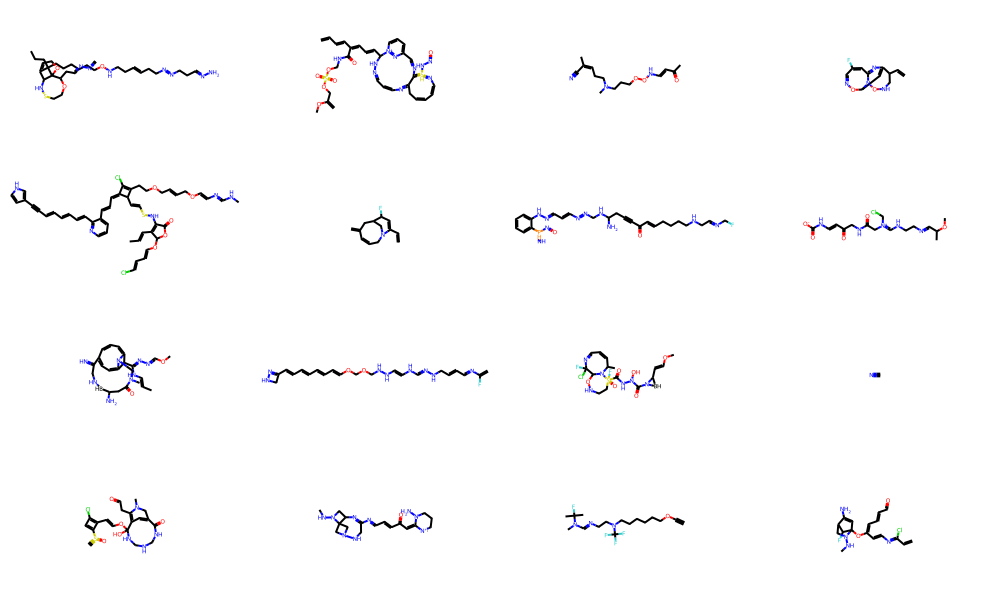

save model:  model_save/epoch_1.pt


epoch 2: 100%|██████████| 106/106 [00:31<00:00,  3.35it/s]


epoch 2, train_loss: 65.147
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 98.828 %
---> visualize


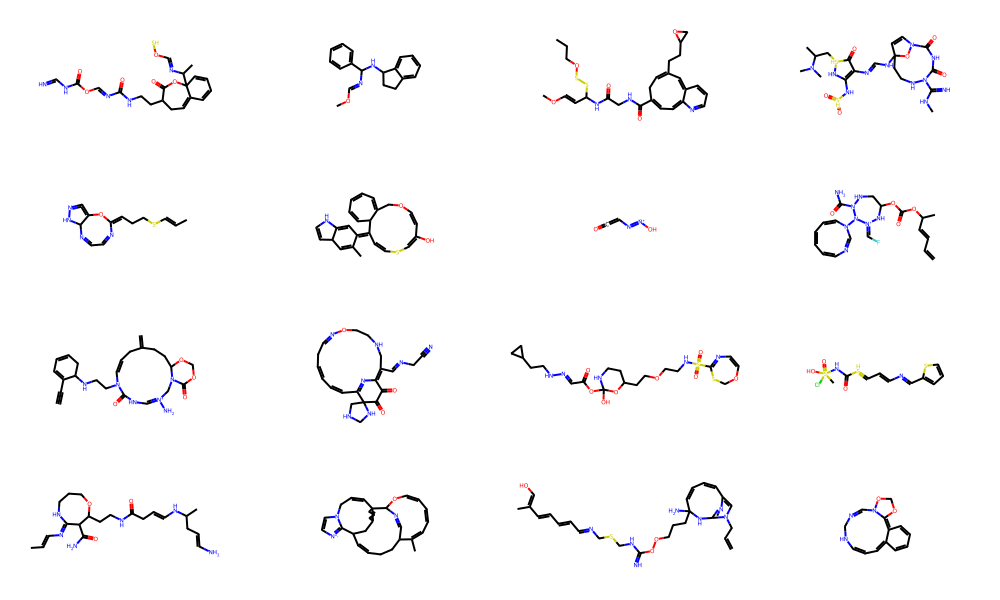

save model:  model_save/epoch_2.pt


epoch 3: 100%|██████████| 106/106 [00:30<00:00,  3.50it/s]


epoch 3, train_loss: 57.050
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 99.023 %
---> visualize


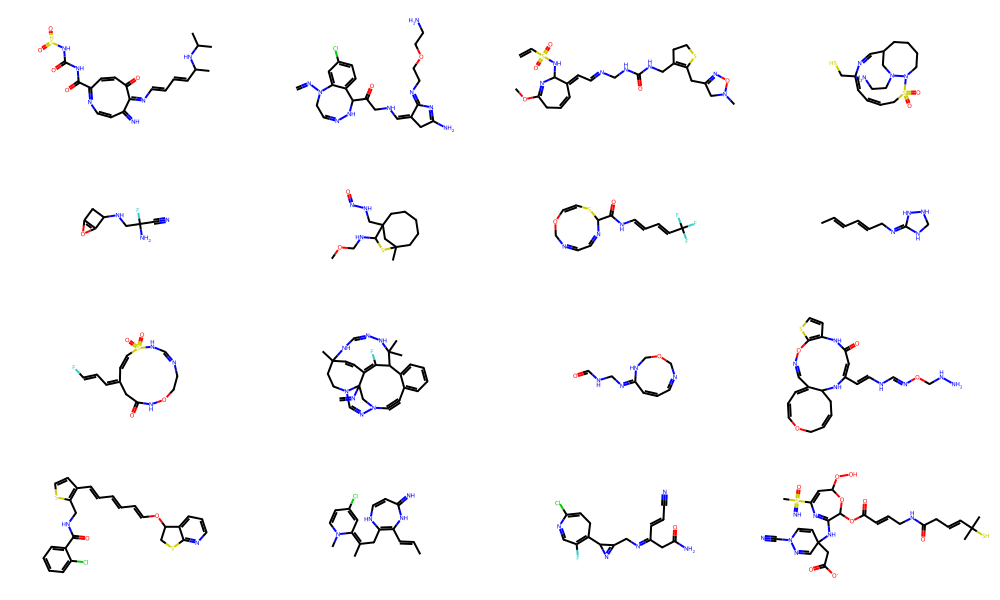

save model:  model_save/epoch_3.pt


epoch 4: 100%|██████████| 106/106 [00:30<00:00,  3.44it/s]


epoch 4, train_loss: 52.702
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  99.902 % | unique: 99.414 %
---> visualize


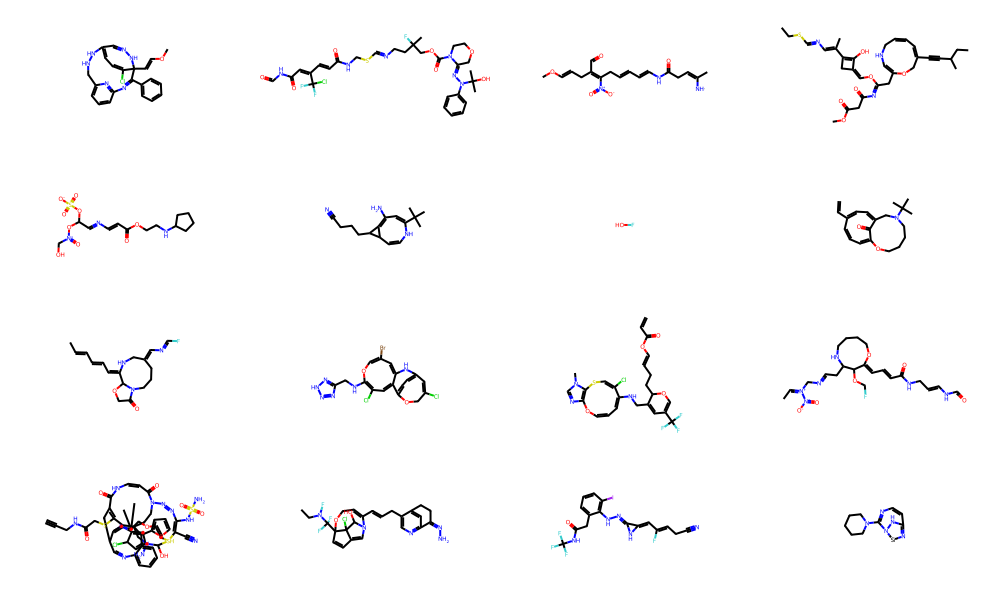

save model:  model_save/epoch_4.pt


epoch 5: 100%|██████████| 106/106 [00:30<00:00,  3.44it/s]


epoch 5, train_loss: 49.605
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 99.316 %
---> visualize


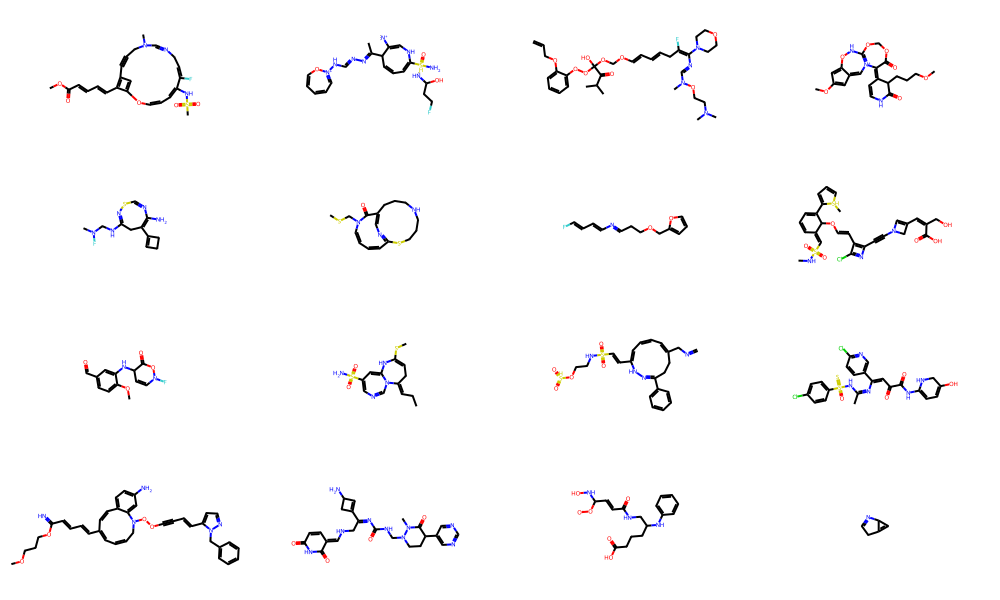

save model:  model_save/epoch_5.pt


epoch 6: 100%|██████████| 106/106 [00:30<00:00,  3.46it/s]


epoch 6, train_loss: 47.281
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 99.512 %
---> visualize


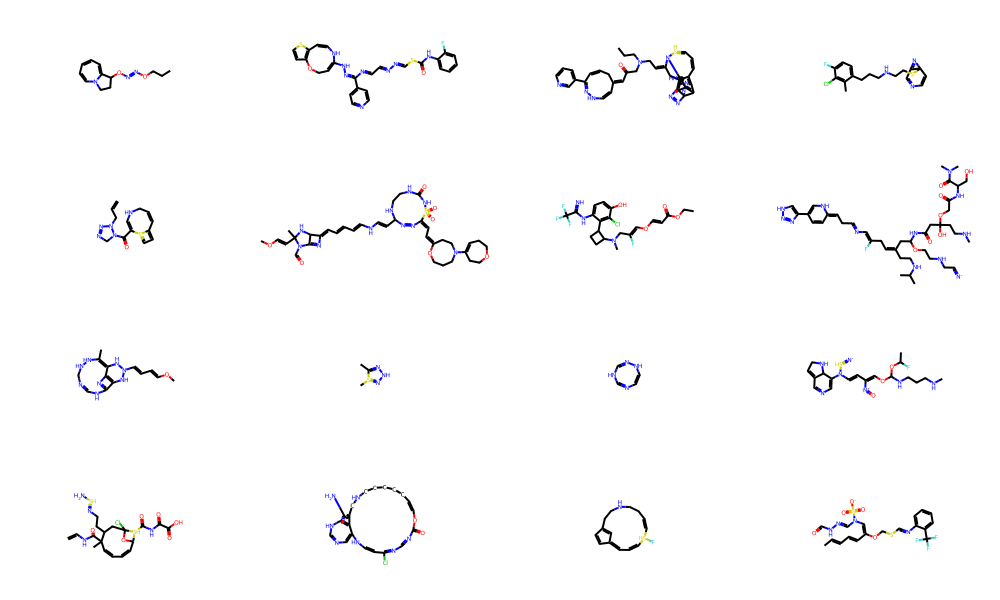

save model:  model_save/epoch_6.pt


epoch 7: 100%|██████████| 106/106 [00:30<00:00,  3.46it/s]


epoch 7, train_loss: 45.347
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 99.805 %
---> visualize


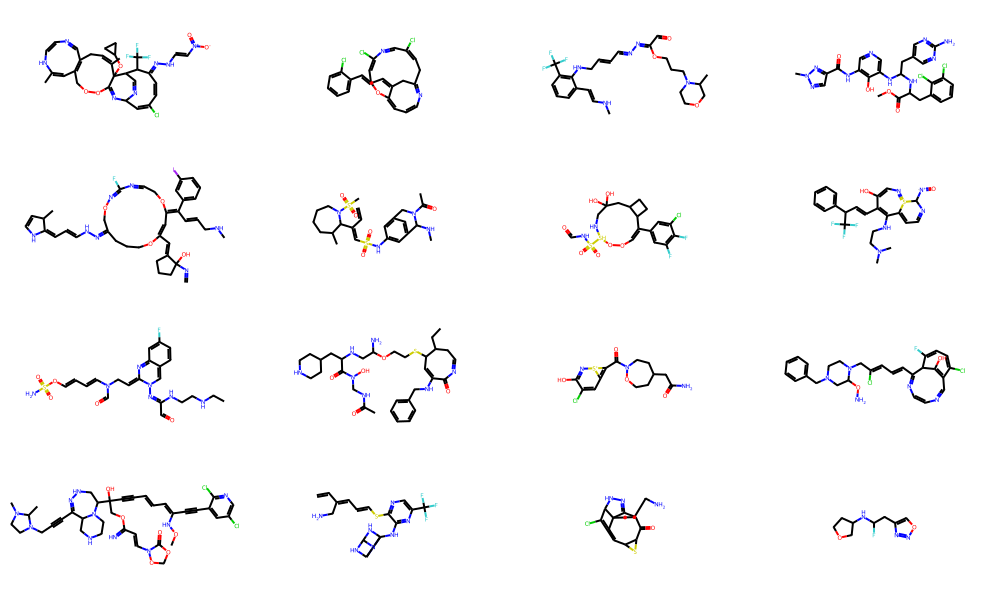

save model:  model_save/epoch_7.pt


epoch 8: 100%|██████████| 106/106 [00:30<00:00,  3.45it/s]


epoch 8, train_loss: 43.827
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 99.609 %
---> visualize


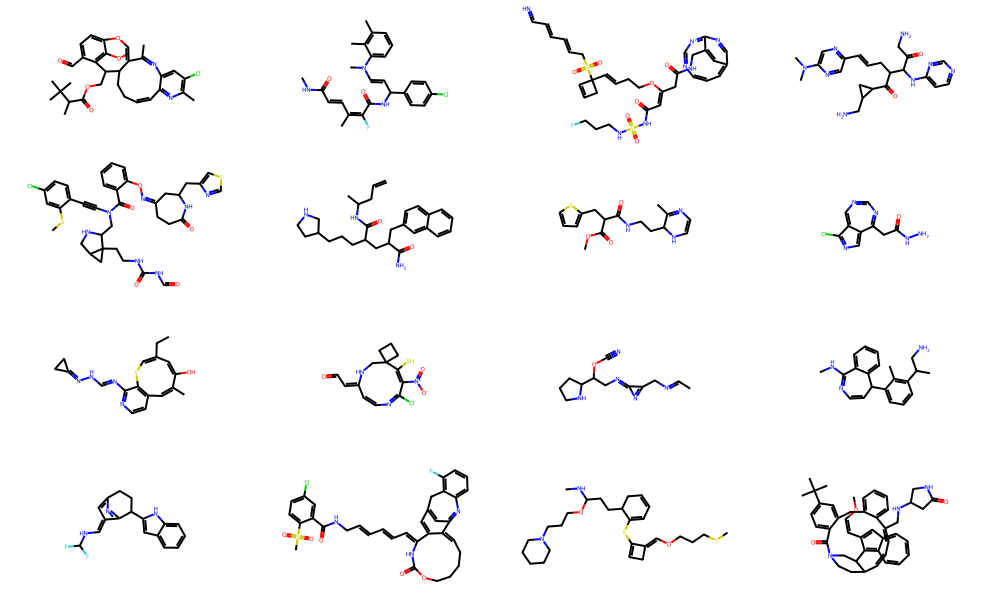

save model:  model_save/epoch_8.pt


epoch 9: 100%|██████████| 106/106 [00:30<00:00,  3.43it/s]


epoch 9, train_loss: 42.685
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 99.902 %
---> visualize


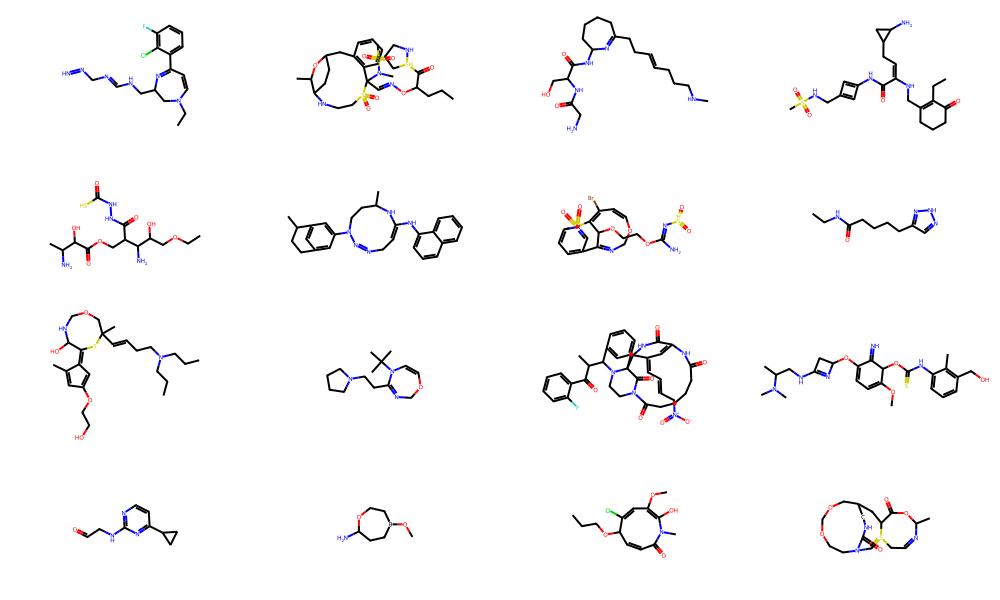

save model:  model_save/epoch_9.pt


epoch 10: 100%|██████████| 106/106 [00:30<00:00,  3.44it/s]


epoch 10, train_loss: 41.149
[sample] total: 1024, 1024| valid 1024
sampling, 100.000% valid convertable selfies -> smiles
valid:  100.000 % | unique: 99.902 %
---> visualize


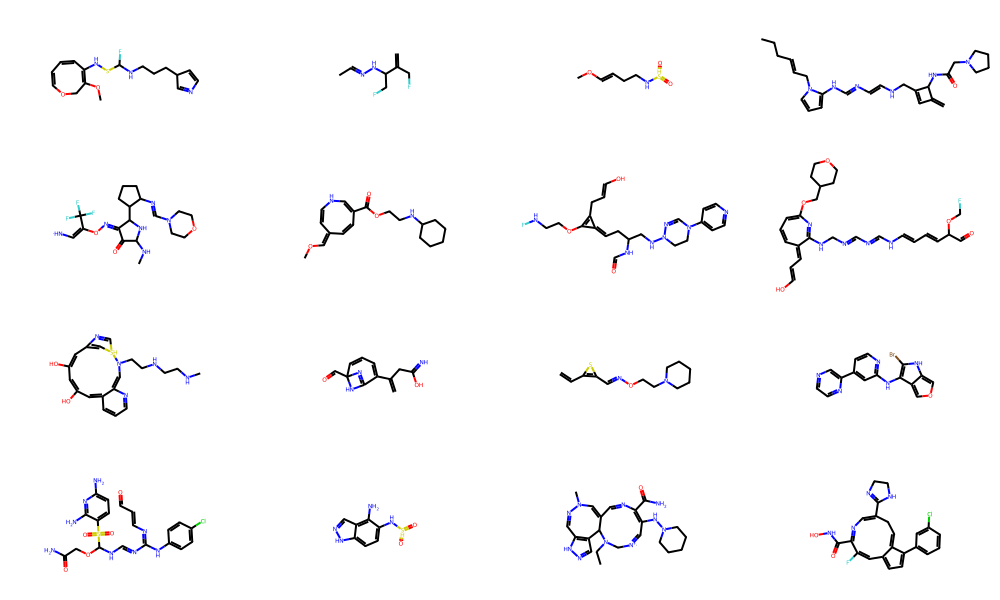

save model:  model_save/epoch_10.pt


In [493]:
if best_epoch != 0:
    load_model(model, out_dir + f'epoch_{best_epoch}.pt')

# device = 'cuda'

for epoch in range(1, 1+num_epoch):
    model.train()
    train_loss = 0
    for data, lengths in tqdm(dataloader, total=len(dataloader),
                              desc=f'epoch {epoch}'): # batch_size = 512
        # print(lengths)
        lengths = [l-1 for l in lengths]
        optimizer.zero_grad()
        # if cuda: data = data.cuda()
        data = data.to(device)

        # preds, _, _ = model(data, lengths)
        _, preds, _ = model(data, lengths)

        # print(preds.shape)

        targets = pack_padded_sequence(
            data[:, 1:], lengths, batch_first=True, enforce_sorted=False).data

        # targets = data


        # preds: [num, len_alphabet-2], target: [num]
        # print('hre pred, target, ', preds.shape, targets.shape)
        # preds = preds.view(-1, preds.shape[-1])
        # targets = data
        # targets = targets.reshape(-1)
        loss = loss_function(preds, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/train_size)
    print(f'epoch {epoch}, train_loss: {train_losses[-1]:.3f}')
    scheduler.step(train_losses[-1])
    sampled_molecules = sample_enc(model, num_drugs=1024, max_len=140)
    valid, unique = compute_valid_rate(sampled_molecules)
    print(f'valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
    if valid > best_valid_rate:

        print('---> visualize')
        visual_mol(sampled_molecules)

        best_epoch = epoch
        trained_model_dir = out_dir + f'epoch_{epoch}.pt'
        print(f'save model: ', trained_model_dir)
        save_model(model, trained_model_dir)
        model_names.append(trained_model_dir)
        while len(model_names) > 10:
            try:
                remove_name = model_names.pop(0)
                print('remove ', remove_name)
                os.remove(remove_name)
            except: print(f'error remove {model_names[0]}')


In [422]:
# def sample(model, num_drugs, max_len, latent_size=rnn_config['latent_size']):

model.sample(10).shape

torch.Size([10, 141])

In [371]:
next(model.parameters()).is_cuda

True

In [382]:



new_j = [d-1 for d in j]
z, mu, logvar = model(i, new_j)
z.shape, mu.shape, logvar.shape

TypeError: ignored

In [ ]:
import yaml
import os
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
import selfies as sf
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
import torch
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    cuda = torch.cuda.is_available()
    if cuda: device = 'cuda'
    else: device = 'cpu'
    model.load_state_dict(torch.load(path, map_location=device))


def sample(model, num_drugs, max_len, vocab=vocab):
    model.eval()
    if next(model.parameters()).is_cuda: device = 'cuda'
    else: device = 'cpu'
    latent_size = model.latent_size
    latents = torch.randn([num_drugs, latent_size]).to(device)
    sample_ints = model.sample(max_len, latents).to(device)
    if device == 'cpu': sample_ints = sample_ints.tolist()
    else: sample_ints = sample_ints.cpu().detach().numpy().tolist()
    molecules = []
    for ints in sample_ints:
        mol = []
        for x in ints:
            if vocab.int2token[x] == '<pad>': break
            else: mol.append(vocab.int2token[x])
        string_mol = "".join(mol)
        molecules.append(string_mol)
    valid_smiles = []
    # nonvalid = 0
    if vocab.name == 'selfies':
        for x in molecules:
            try:
                smi = sf.decoder(x)
                valid_smiles.append(smi)
            except: pass
    print(f'sampling, {(len(valid_smiles)/num_drugs * 100):.3f}%',
          'convertable selfies -> smiles')
    return valid_smiles

def compute_valid_rate(molecules):
    num_valid, num_invalid = 0, 0
    valid_mols = set()
    for i in molecules:
        mol = Chem.MolFromSmiles(i)
        if mol is None: num_invalid +=1
        else:
            num_valid += 1
            valid_mols.add(i)
    assert len(molecules) == num_valid + num_invalid
    unique_num = len(valid_mols)
    # print(unique_num)
    valid_rate = num_valid / len(molecules)
    unique_rate = unique_num / len(molecules)
    return valid_rate, unique_rate



def visual_mol(smiles, mol_num=16):
    from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
    import random
    import math
    from rdkit import Chem
    mol_conv = Chem.MolFromSmiles

    """
    randomly display mol_num of smiles from list
    """
    show_num = min(len(smiles), mol_num)
    selected_smiles = random.choices([*set(smiles)], k=show_num)
    molecules = [mol_conv(i) for i in selected_smiles]
    img = MolsToGridImage(
        [m for m in molecules if m is not None],
        molsPerRow=int(math.sqrt(show_num)),
        subImgSize=(250, 150),  returnPNG=False)
    display(img)

sampled_molecules = sample_enc(model, num_drugs=1024, max_len=140)

In [286]:
compute_valid_rate(sample(decoder, 12, max_len=10))

sampling, 8.333% invalid selfies -> smiles


(1.0, 1.0)

In [ ]:
class VAE(nn.Module):
    def __init__(self, rnn_config):
        self.enc = RNNEncoder(rnn_config)
        self.dec = RNNDecoder(rnn_config)
        self.beta = rnn_config['beta'] # control KLD weight
        self.gamma = rnn_config['gamma'] # control classifier weight

    def get_elbo(self, x, length):
        z, mu, logvar =


In [287]:
model = RNNEncoder(rnn_config).to(device)
learning_rate = rnn_config['learning_rate']
weight_decay = rnn_config['weight_decay']
loss_function = nn.CrossEntropyLoss(reduction='sum')

if rnn_config['which_optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
elif rnn_config['which_optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                weight_decay=weight_decay, momentum=0.9)
elif rnn_config['which_optimizer'] == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
else: raise ValueError('wrong optimizer. should be adam, sgd or adamw')

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                              cooldown=10, min_lr=1e-4, verbose=True)

NameError: ignored

In [285]:
z = torch.randn([2, 256])

a = decoder.sample(10, z)
a

tensor([[11, 22, 58, 48, 51, 54, 76, 71, 54, 65],
        [46, 46, 46, 46, 46, 46, 46, 46, 46, 46]])

torch.Size([512, 109])

torch.Size([512, 109, 78])

tensor([[22, 71, 40, 17, 13, 56, 13, 17, 13, 46],
        [33, 48, 17, 33, 48, 17, 33, 48, 17, 33]])

In [222]:
vocab.int2token[76]

'<pad>'

In [231]:
# mols = []
# for ints in a.tolist():
#     print(ints)
#     s_mol = []
#     for x in ints:
#         print(x)
#         if vocab.int2token[x] != '<pad>':
#             s_mol.append(vocab.int2token[x])
#             print(s_mol)
#         else: print('NO!')

#     mols.append("".join(s_mol))
#     print(mols)
# mols = [sf.decoder(x) for x in mols]

In [196]:
mols

['[Se+1][C-1]=O', '[BH2-1]I']

In [264]:
for ad in a:
    for zd in ad:
        if zd == 76:
            print('True')


In [110]:
i.shape

torch.Size([64, 96])

In [284]:
decoder = DilConvDecoder(rnn_config)
decoder.get_logits(i, z).shape

torch.Size([64, 107, 77])

In [366]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# from gentrl.tokenizer import get_vocab_size, encode, decode


class DilConvDecoder(nn.Module):
    '''
    Class for autoregressive model that works in WaveNet manner.
        It make conditinioning on previosly sampled tokens by running
        stack of dilation convolution on them.
    '''
    def __init__(self, rnn_config, vocab=vocab):

                #  latent_input_size, token_weights=None,
                #  split_len=50, num_dilated_layers=7, num_channels=128):
        r'''
        Args:
            latent_input_size: int, size of latent code used in VAE-like models
            token_weights: Tensor of shape [num_tokens], where i-th element
                    contains the weight of i-th token. If None, then all
                    tokens has the same weight.
            split_len: int, maximum length of token sequence
            num_dilated_layers: int, how much dilated layers is in stack
            num_channels: int, num channels in convolutional layers
        '''
        super(DilConvDecoder, self).__init__()
        # self.vocab_size = rnn_config['num_embeddings']
        self.latent_size = rnn_config['latent_size']
        self.split_len = rnn_config['max_token_len']
        self.num_dilated_layers = rnn_config['num_dilated_layers']
        self.num_channels = rnn_config['num_channels']
        self.token_weights = rnn_config['token_weights']
        try: self.eos = vocab.vocab['<pad>']
        except: self.eos = rnn_config['num_embeddings']-1

        cur_dil = 1
        self.dil_conv_layers = []
        for i in range(self.num_dilated_layers):
            self.dil_conv_layers.append(
                    DilConv1dWithGLU(self.num_channels, cur_dil))
            cur_dil *= 2

        # self.input_embeddings = nn.Embedding(self.vocab_size,
        #                             rnn_config['num_channels'])

        self.input_embeddings = nn.Embedding(
                        num_embeddings = rnn_config['num_embeddings'],
                        embedding_dim = rnn_config['num_channels'],
                        padding_idx = rnn_config['num_embeddings'] - 1)

        self.latent_fc = nn.Linear(rnn_config['latent_size'],
                                   rnn_config['num_channels'])


        self.logits_1x1_layer = nn.Conv1d(rnn_config['num_channels'],
                                          rnn_config['num_embeddings'],
                                          kernel_size=1)

        cur_parameters = []
        for layer in [self.input_embeddings, self.logits_1x1_layer,
                      self.latent_fc] + self.dil_conv_layers:
            cur_parameters += list(layer.parameters())

        self.parameters = nn.ParameterList(cur_parameters)

    def get_logits(self, input_tensor, z, sampling=False):
        '''
        Computing logits for each token input_tensor by given latent code

        [WORKS ONLY IN TEACHER-FORCING MODE]

        Args:
            input_tensor: Tensor of shape [batch_size, max_seq_len]
            z: Tensor of shape [batch_size, lat_code_size]
        '''

        input_embedded = self.input_embeddings(input_tensor).transpose(1, 2)
        latent_embedded = self.latent_fc(z)

        x = input_embedded + latent_embedded.unsqueeze(-1)

        for dil_conv_layer in self.dil_conv_layers:
            x = dil_conv_layer(x, sampling=sampling)
        # print('before conv_layer x', x.shape) # [64, 128, 78]
        x = self.logits_1x1_layer(x).transpose(1, 2)

        # print('conv_layer x:' ,x.shape)
        # conv_layer x: torch.Size([64, 78, 75])


        return F.log_softmax(x, dim=-1) # torch.Size([64, 78, 75])

    def get_log_prob(self, x, z):
        '''
        Getting logits of SMILES sequences
        Args:
            x: tensor of shape [batch_size, seq_size] with tokens
            z: tensor of shape [batch_size, lat_size] with latents
        Returns:
            logits: tensor of shape [batch_size, seq_size]
        '''
        seq_logits = torch.gather(self.get_logits(x, z)[:, :-1, :],
                                  2, x[:, 1:].long().unsqueeze(-1))
        # get rid of x[:, 1], which is '<sos>'
        return seq_logits[:, :, 0]

    def forward(self, x, z):
        '''
        Getting logits of SMILES sequences
        Args:
            x: tensor of shape [batch_size, seq_size] with tokens
            z: tensor of shape [batch_size, lat_size] with latents
        Returns:
            logits: tensor of shape [batch_size, seq_size]
            None: since dilconv decoder doesn't have hidden state unlike RNN
        '''
        return self.get_log_prob(x, z), None

    def weighted_forward(self, x, z):
        '''
        '''
        x = x.to(self.input_embeddings.weight.data.device)

        seq_logits = self.get_log_prob(x, z)

        if self.token_weights is not None:
            w = self.token_weights[x[:, 1:].long().contiguous().view(-1)]
            w = w.view_as(seq_logits)
            seq_logits = seq_logits * w

        non_eof = (x != self.eos)[:, :-1].float()
        ans_logits = (seq_logits * non_eof).sum(dim=-1)
        ans_logits /= non_eof.sum(dim=-1)

        return ans_logits

    def sample(self, max_len, latents, argmax=True, vocab=vocab):
        ''' Sample SMILES for given latents

        Args:
            latents: tensor of shape [n_batch, n_features]

        Returns:
            logits: tensor of shape [batch_size, seq_size], logits of tokens
            tokens: tensor of shape [batch_size, seq_size], sampled token
            None: since dilconv decoder doesn't have hidden state unlike RNN

        '''

        # clearing buffers
        for dil_conv_layer in self.dil_conv_layers:
            dil_conv_layer.clear_buffer()

        num_objects = latents.shape[0]
        device_here = latents.device.type
        finish = torch.zeros(latents.shape[0], dtype=torch.bool).to(device_here)
        try:
            start_int = vocab.vocab['<sos>']
        except: raise ValueError('No vocab')
        # except: start_int = self.vocab_size
        ans_seqs = [[1* start_int] for _ in range(num_objects)]
        # ans_logits = []

        cur_tokens = torch.tensor(ans_seqs, device=latents.device).long()

        output = []
        for s in range(max_len):
            logits = self.get_logits(cur_tokens, latents, sampling=True)
            logits = logits.detach()
            logits = torch.log_softmax(logits[:, 0, :], dim=-1)
            # ans_logits.append(logits.unsqueeze(0))

            if argmax:
                cur_tokens = torch.max(logits, dim=-1)[1].unsqueeze(-1)
            else:
                cur_tokens = torch.multinomial(F.softmax(logits, dim=-1), 1)

            det_tokens = cur_tokens.cpu().detach().tolist()
            # print(ans_seqs)
            ans_seqs = [a + b for a, b in zip(ans_seqs, det_tokens)]
            # print(ans_seqs)

            # print()
            # print(ans_seqs)
            # output.append(det_tokens)
            eos_sampled = (cur_tokens == vocab.vocab['<pad>']).data
            finish = torch.logical_or(finish, eos_sampled.squeeze())
            if torch.all(finish):
                # output_all = torch.cat(output, -1)
                break

        # output_all = torch.cat(output, -1)

            # ans_seqs = [a + b for a, b in zip(ans_seqs, det_tokens)]

        # clearing buffers
        for dil_conv_layer in self.dil_conv_layers:
            dil_conv_layer.clear_buffer()

        # ans_logits = torch.cat(ans_logits, dim=0)

        ans_seqs = torch.tensor(ans_seqs)[:, 1:]
        return ans_seqs
        # return decode(ans_seqs)

        # return output_all

class DilConv1dWithGLU(nn.Module):
    def __init__(self, num_channels, dilation, lenght=100,
                 kernel_size=2, activation=F.leaky_relu,
                 residual_connection=True, dropout=0.2):

        super(DilConv1dWithGLU, self).__init__()

        self.dilation = dilation

        self.start_ln = nn.LayerNorm(num_channels)
        self.start_conv1x1 = nn.Conv1d(num_channels, num_channels,
                                       kernel_size=1)

        self.dilconv_ln = nn.LayerNorm(num_channels)
        self.dilated_conv = nn.Conv1d(num_channels, num_channels,
                                      dilation=dilation,
                                      kernel_size=kernel_size,
                                      padding=dilation)

        self.gate_ln = nn.LayerNorm(num_channels)
        self.end_conv1x1 = nn.Conv1d(num_channels, num_channels,
                                     kernel_size=1)
        self.gated_conv1x1 = nn.Conv1d(num_channels, num_channels,
                                       kernel_size=1)

        self.activation = activation

        self.buffer = None

        self.residual_connection = residual_connection

    def clear_buffer(self):
        self.buffer = None

    def forward(self, x_inp, sampling=False):
        # applying 1x1 convolution
        x = self.start_ln(x_inp.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        x = self.start_conv1x1(x)

        # applying dilated convolution
        # if in sampling mode
        x = self.dilconv_ln(x.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        if sampling:
            if self.buffer is None:
                self.buffer = x
            else:
                pre_buffer = torch.cat([self.buffer, x], dim=2)
                self.buffer = pre_buffer[:, :, -(self.dilation + 1):]

            if self.buffer.shape[2] == self.dilation + 1:
                x = self.buffer
            else:
                x = torch.cat([torch.zeros(self.buffer.shape[0],
                                           self.buffer.shape[1],
                                           self.dilation + 1
                                           - self.buffer.shape[2],
                                           device=x_inp.device), self.buffer],
                              dim=2)

            x = self.dilated_conv(x)[:, :, self.dilation:]
            x = x[:, :, :x_inp.shape[-1]]
        else:
            x = self.dilated_conv(x)[:, :, :x_inp.shape[-1]]

        # applying gated linear unit
        x = self.gate_ln(x.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        x = self.end_conv1x1(x) * torch.sigmoid(self.gated_conv1x1(x))

        # if residual connection
        if self.residual_connection:
            x = x + x_inp

        return x


In [444]:
PADDING_IDX = vocab.vocab['<pad>']

In [ ]:
smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'

batch_size = rnn_config['batch_size']
shuffle = rnn_config['shuffle']
PADDING_IDX = vocab.vocab('<pad>')
num_workers = os.cpu_count()

print(rnn_config)
dataset_dir = smile_dir
which_vocab = 'selfies'
vocab_path = selfie_vocab_path
percentage = 0.1


print('number of workers to load data:', num_workers)
print('which vocab to use: ', which_vocab)

new_selfie_vocab_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_no_eos.yaml'
vocab = SELFIEVocab(new_selfie_vocab_path)
try:
    assert(rnn_config['num_embeddings'] == len(vocab.vocab))
except:
    raise ValueError('difference in len alphabet, change rnn_config')

dataloader, train_size = dataloader_gen(percentage, batch_size, PADDING_IDX,
                                        shuffle, drop_last=False)

# decoder = DilConvDecoder(rnn_config)
# decoder.get_logits(i, z).shape


torch.Size([64, 78, 76])

which_vocab: selfies
total number of SMILES loaded:  53824


100%|██████████| 53824/53824 [00:29<00:00, 1808.76it/s]

total valid SELFIES: 53824


In [258]:
for i, j in dataloader:
    i, j

a = decoder(i, z)
a = decoder.weighted_forward(i, z)
a.shape, decoder.get_log_prob(i, z).shape, decoder.get_logits(i, z)[:, :-1, :].shape

(torch.Size([64]), torch.Size([64, 103]), torch.Size([64, 103, 77]))

In [259]:
decoder.get_logits(i, z).shape

torch.Size([64, 104, 77])